# A notebook to to get true and predicted CTann and RUI for HRApop atlas datasets


## Goal

See [this GitHub issue](https://github.com/x-atlas-consortia/hra-pop/issues/100)


## Import libraries


In [2]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pprint import pprint
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

## Set global variables


In [3]:
hra_pop_version = "v0.10.3"

## Load data


In [4]:
# df_x = pd.read_csv("data/validation-v7-ctann-rui.csv")
df_x = pd.read_csv(
  f"../../../hra-pop/output-data/{hra_pop_version}/reports/atlas/validation-v7-x-axis.csv")
df_y = pd.read_csv(
  f"../../../hra-pop/output-data/{hra_pop_version}/reports/atlas/validation-v7-y-axis.csv")

## Prepare data for visualization and visualize


In [5]:
df_x

,sex,sample,rui_location,dataset,tool,modality,organ,organId,datasetVsRuiSim
0,Female,https://doi.org/10.1126/science.abl4290#GTEX-1...,http://purl.org/ccf/1.5/3b5d2036-3c56-4cf8-808...,https://doi.org/10.1126/science.abl4290#GTEX-1...,popv,sc_transcriptomics,Set of lactiferous glands in right breast,FMA:57987,0.950079
1,Female,https://doi.org/10.1126/science.abl4290#GTEX-1...,http://purl.org/ccf/1.5/3b5d2036-3c56-4cf8-808...,https://doi.org/10.1126/science.abl4290#GTEX-1...,popv,sc_transcriptomics,Set of lactiferous glands in right breast,FMA:57987,0.944614
2,Female,https://doi.org/10.1126/science.abl4290#GTEX-1...,http://purl.org/ccf/1.5/3b5d2036-3c56-4cf8-808...,https://doi.org/10.1126/science.abl4290#GTEX-1...,popv,sc_transcriptomics,Set of lactiferous glands in right breast,FMA:57987,0.934930
3,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.911356
4,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.701952
...,...,...,...,...,...,...,...,...,...
902,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/e21afc3c-3a7c-4717-90d...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,spleen,UBERON:0002106,0.744703
903,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/b2aca02c-9559-4869-b55...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,1.000000
904,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/e43280c9-840b-481f-a8a...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.998475
905,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/fb6bb0ea-5ba7-44e2-90a...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.913469


In [6]:
df_y

,sex,rui_location,dataset,tool,predicted_rui,similarity
0,Female,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7...,https://api.cellxgene.cziscience.com/dp/v1/col...,celltypist,http://purl.org/ccf/1.5/05c11830-1526-4472-bd1...,0.441815
1,Female,http://purl.org/ccf/1.5/8f99a469-7d51-46dc-919...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/731ade72-cdb7-4262-8be...,0.792217
2,Female,http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864...,https://doi.org/10.1126/science.abl4290#GTEX-1...,popv,http://purl.org/ccf/1.5/ca476545-5b98-476c-b2f...,0.951883
3,Male,http://purl.org/ccf/1.5/886e391d-0151-46d3-8a5...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864...,0.957861
4,Male,http://purl.org/ccf/1.5/da28394d-789a-4fba-842...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864...,0.945847
...,...,...,...,...,...,...
927,Male,http://purl.org/ccf/1.5/aba1ebe3-af18-40cc-b53...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/fd4fcec2-93c3-428f-ad3...,0.925139
928,Male,http://purl.org/ccf/1.5/ca23f77c-a3cd-453f-bbe...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/1f414fc5-cb93-45b7-a1b...,0.855982
929,Male,http://purl.org/ccf/1.5/d662fd53-e925-4921-8d8...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/aba1ebe3-af18-40cc-b53...,0.991318
930,Male,http://purl.org/ccf/1.5/df0b33f7-371a-47a4-a63...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/db35f27d-313f-4dd6-819...,0.911654


## Compute similarity scores for %AS


### Load atlas enriched dataset graph


In [7]:
ds_graph_path = f"../../../hra-pop/output-data/{
  hra_pop_version}/atlas-enriched-dataset-graph.jsonld"

with open(ds_graph_path) as f:
  graph = json.load(f)

### Define functions


In [8]:
def dict_to_vec(dict1: dict, dict2: dict):
  """Takes two dictionaries and returns a tuple of nornalized lists with values (0 if key not present)

  Args:
    dict1 (dict): dictionary 1
    dict2 (dict): dictionary 2
  Returns:
    result (tuple): a tuple with normalized lists
  """

  # initialize result
  dict1_list = []
  dict2_list = []

  # handle shared keys
  shared_keys = set(dict1['collisions'].keys()).intersection(
    dict2['collisions'].keys())

  for key in shared_keys:
    dict1_list.append(dict1['collisions'][key])
    dict2_list.append(dict2['collisions'][key])

  # handle not shared keys
  keys_in_dict1_not_in_dict2 = dict1.keys() - dict2.keys()
  for key in keys_in_dict1_not_in_dict2:
    dict1[key] = 0

  keys_in_dict2_not_in_dict1 = dict2.keys() - dict1.keys()
  for key in keys_in_dict2_not_in_dict1:
    dict1[key] = 0

  return (dict1_list, dict2_list)


def get_as_collision_items(iri: str):
  """A function to get AS collision items for an IRI (extraction site) and return a dictionary with AS UBERON ID and intersection percentage of the extraction site

  Args:
    iri (str): an IRI for an extraction site

  Returns:
    a dictionary with the IRI and a nested dictionary with collisions (ID and percentage) 
  """

  result = {

  }

  # loop through ds graph
  for donor in graph['@graph']:
    for sample in donor['samples']:
      current = sample['rui_location']
      if current['@id'] == iri:
        # print(current['all_collisions'])
        for collision_summary in current['all_collisions']:
          for item in collision_summary['collisions']:
            result[item['as_id']] = item['percentage']

  return result


def compute_cosine_similarity_by_as_percentage(iri_1: str, iri_2: str):
  """Takes two IRIs of extraction sites and returns the cosine similarity of their AS percentages

  Args:
          iri_1 (str): An IRI for an extraction site
          iri_2 (str): An IRI for an extraction site

Returns: 
          similarity (float): A cosine similarity
  """

  # For debugging
  # print()
  # print(f"Now comparing {iri_1} and {iri_2}")

  # Get AS collision items as dict
  dict1 = get_as_collision_items(iri_1)
  dict2 = get_as_collision_items(iri_2)

  # pprint(f"dict1: {dict1}")
  # pprint(f"dict2: {dict2}")

  # Get a combined set of all keys from both dictionaries
  all_keys = set(dict1.keys()).union(dict2.keys())

  # Create the two lists of values
  values1 = [dict1.get(key, 0) for key in all_keys]
  values2 = [dict2.get(key, 0) for key in all_keys]

  # print(values1)
  # print(values2)

  # Compute cosine similarity
  cosine_similarity_value = cosine_similarity([values1], [values2])
  # print(f"Cosine Similarity: {cosine_similarity_value[0][0]}")

  return float(cosine_similarity_value[0][0])

### Loop through pairs of extraction sites (true and predicted) in validation and compute AS% similarity score


In [9]:
# Add a new column with the AS% cosine similarity
df_y['as_percentage_cosine_sim'] = df_y.apply(lambda row: compute_cosine_similarity_by_as_percentage(
  row['rui_location'], row['predicted_rui']), axis=1)

# Save to CSV for optinal inspection in external software
df_y.to_csv("output/df_y.csv")

# print for review inline
df_y

,sex,rui_location,dataset,tool,predicted_rui,similarity,as_percentage_cosine_sim
0,Female,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7...,https://api.cellxgene.cziscience.com/dp/v1/col...,celltypist,http://purl.org/ccf/1.5/05c11830-1526-4472-bd1...,0.441815,0.532793
1,Female,http://purl.org/ccf/1.5/8f99a469-7d51-46dc-919...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/731ade72-cdb7-4262-8be...,0.792217,1.000000
2,Female,http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864...,https://doi.org/10.1126/science.abl4290#GTEX-1...,popv,http://purl.org/ccf/1.5/ca476545-5b98-476c-b2f...,0.951883,1.000000
3,Male,http://purl.org/ccf/1.5/886e391d-0151-46d3-8a5...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864...,0.957861,0.000000
4,Male,http://purl.org/ccf/1.5/da28394d-789a-4fba-842...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864...,0.945847,0.000000
...,...,...,...,...,...,...,...
927,Male,http://purl.org/ccf/1.5/aba1ebe3-af18-40cc-b53...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/fd4fcec2-93c3-428f-ad3...,0.925139,0.970143
928,Male,http://purl.org/ccf/1.5/ca23f77c-a3cd-453f-bbe...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/1f414fc5-cb93-45b7-a1b...,0.855982,0.000000
929,Male,http://purl.org/ccf/1.5/d662fd53-e925-4921-8d8...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/aba1ebe3-af18-40cc-b53...,0.991318,0.000000
930,Male,http://purl.org/ccf/1.5/df0b33f7-371a-47a4-a63...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/db35f27d-313f-4dd6-819...,0.911654,1.000000


## Visualize


### Create combined DataFrame


In [10]:
# Merging on two columns (key1 and key2)
merged_df = pd.merge(
  df_x, df_y, on=['dataset', 'tool', 'rui_location', 'sex'], how='inner')

# rename similarity columns for plotting


merged_df = merged_df.rename(columns={
  "datasetVsRuiSim": "ctann_sim",
  # RUI (y axis) cosine sim between dataset cell summary vs PREDICTED (most similar) rui location cell summary (*except* its TRUE rui location)
  "similarity": "rui_sim_by_cell_summary",
  "as_percentage_cosine_sim": "rui_sim_as_percentage"
})

merged_df

,sex,sample,rui_location,dataset,tool,modality,organ,organId,ctann_sim,predicted_rui,rui_sim_by_cell_summary,rui_sim_as_percentage
0,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.911356,http://purl.org/ccf/1.5/05c11830-1526-4472-bd1...,0.917636,0.532793
1,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.701952,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967...,0.925033,0.000000
2,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,popv,sc_transcriptomics,heart,UBERON:0000948,0.941554,http://purl.org/ccf/1.5/ca476545-5b98-476c-b2f...,0.971689,0.000000
3,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7...,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.933921,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967...,0.978646,0.000000
4,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7...,https://api.cellxgene.cziscience.com/dp/v1/col...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.474365,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967...,0.916703,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
893,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/e21afc3c-3a7c-4717-90d...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,spleen,UBERON:0002106,0.744703,http://purl.org/ccf/1.5/dc29aac6-af08-4fa4-9d5...,0.744706,0.999982
894,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/b2aca02c-9559-4869-b55...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,1.000000,http://purl.org/ccf/1.5/e43280c9-840b-481f-a8a...,1.000000,1.000000
895,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/e43280c9-840b-481f-a8a...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.998475,http://purl.org/ccf/1.5/cc08d64c-5d75-4995-b3b...,0.998475,1.000000
896,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/fb6bb0ea-5ba7-44e2-90a...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.913469,http://purl.org/ccf/1.5/b2aca02c-9559-4869-b55...,0.913469,1.000000


### Validate data

In [47]:
pd.options.display.max_colwidth = 100

merged_df = merged_df[(merged_df['tool'] == "sc_proteomics")]
merged_df

,sex,sample,rui_location,dataset,tool,modality,organ,organId,ctann_sim,predicted_rui,rui_sim_by_cell_summary,rui_sim_as_percentage


### Build plot


Functions for making plots


In [32]:
def make_validation_scattergraph(x: float, y: float, palette: str, col: str, row: str, hue: str, x_label: str, y_label: str):
    """A wrapper function around a seaborn FacetGrid to make multiple versions of the validation scattergraph

    Args:
                    x (float): x-value
                    y (float): y-value
                    palette (str): Name for color palette
                    col (str): Column of facet grid
                    row (str): Row of facet grid
                    hue (str): Color for points
                    x_label (str): Label on x-axis
            y_label (str): Label on y-axis
    """

    # Create a custom color palette
    custom_palette = sns.color_palette(palette)

    # set font size
    sns.set_theme(font_scale=2)

    # Create FacetGrid
    g = sns.FacetGrid(
        merged_df,
        col=col,
        row=row,
        hue=hue,
        palette=custom_palette,
        height=5,
        aspect=1
    )

    # Set the style of the plot
    # Options: "white", "dark", "whitegrid", "darkgrid", "ticks"
    sns.set_style("whitegrid")

    # Create a scatter plot
    g.map(sns.scatterplot, x, y)

    # Set labels
    g.set(xlabel=x_label, ylabel=y_label)

    # Add a legend
    g.add_legend()

    # Show the plot
    plt.show()

### Data dictionary


| Axis             | Variable                | Explanation                                                                                                                                 |
| ---------------- | ----------------------- | ------------------------------------------------------------------------------------------------------------------------------------------- |
| x                | ctann_sim               | CTann (x axis) Cosine sim between TRUE cell summary of input dataset and PREDICTED cell summary of input RUI location (as computed by US 1) |
| y (cell summary) | rui_sim_by_cell_summary | RUI (y axis) cosine sim between dataset cell summary vs PREDICTED (most similar) rui location cell summary (_except_ its TRUE rui location) |
| y (AS%)          | rui_sim_as_percentage   | RUI (y axis) cosine sim between AS% of TRUE and PREDICTED rui                                                                               |


### CTann vs RUI cosine sim between dataset cell summary vs PREDICTED (most similar) rui location cell summary &#x2705;


In [13]:
# Correlation
stats = merged_df[['ctann_sim', 'rui_sim_by_cell_summary']]
stats.corr(min_periods=3)

,ctann_sim,rui_sim_by_cell_summary
ctann_sim,1.000000,0.680724
rui_sim_by_cell_summary,0.680724,1.000000


In [14]:
# Mean, STDDEV, min, etc.
stats.describe()

,ctann_sim,rui_sim_by_cell_summary
count,898.000000,898.000000
mean,0.832648,0.869627
std,0.159287,0.133640
min,0.117205,0.151411
25%,0.743555,0.811778
50%,0.886364,0.914306
75%,0.953453,0.965113
max,1.000000,1.000000


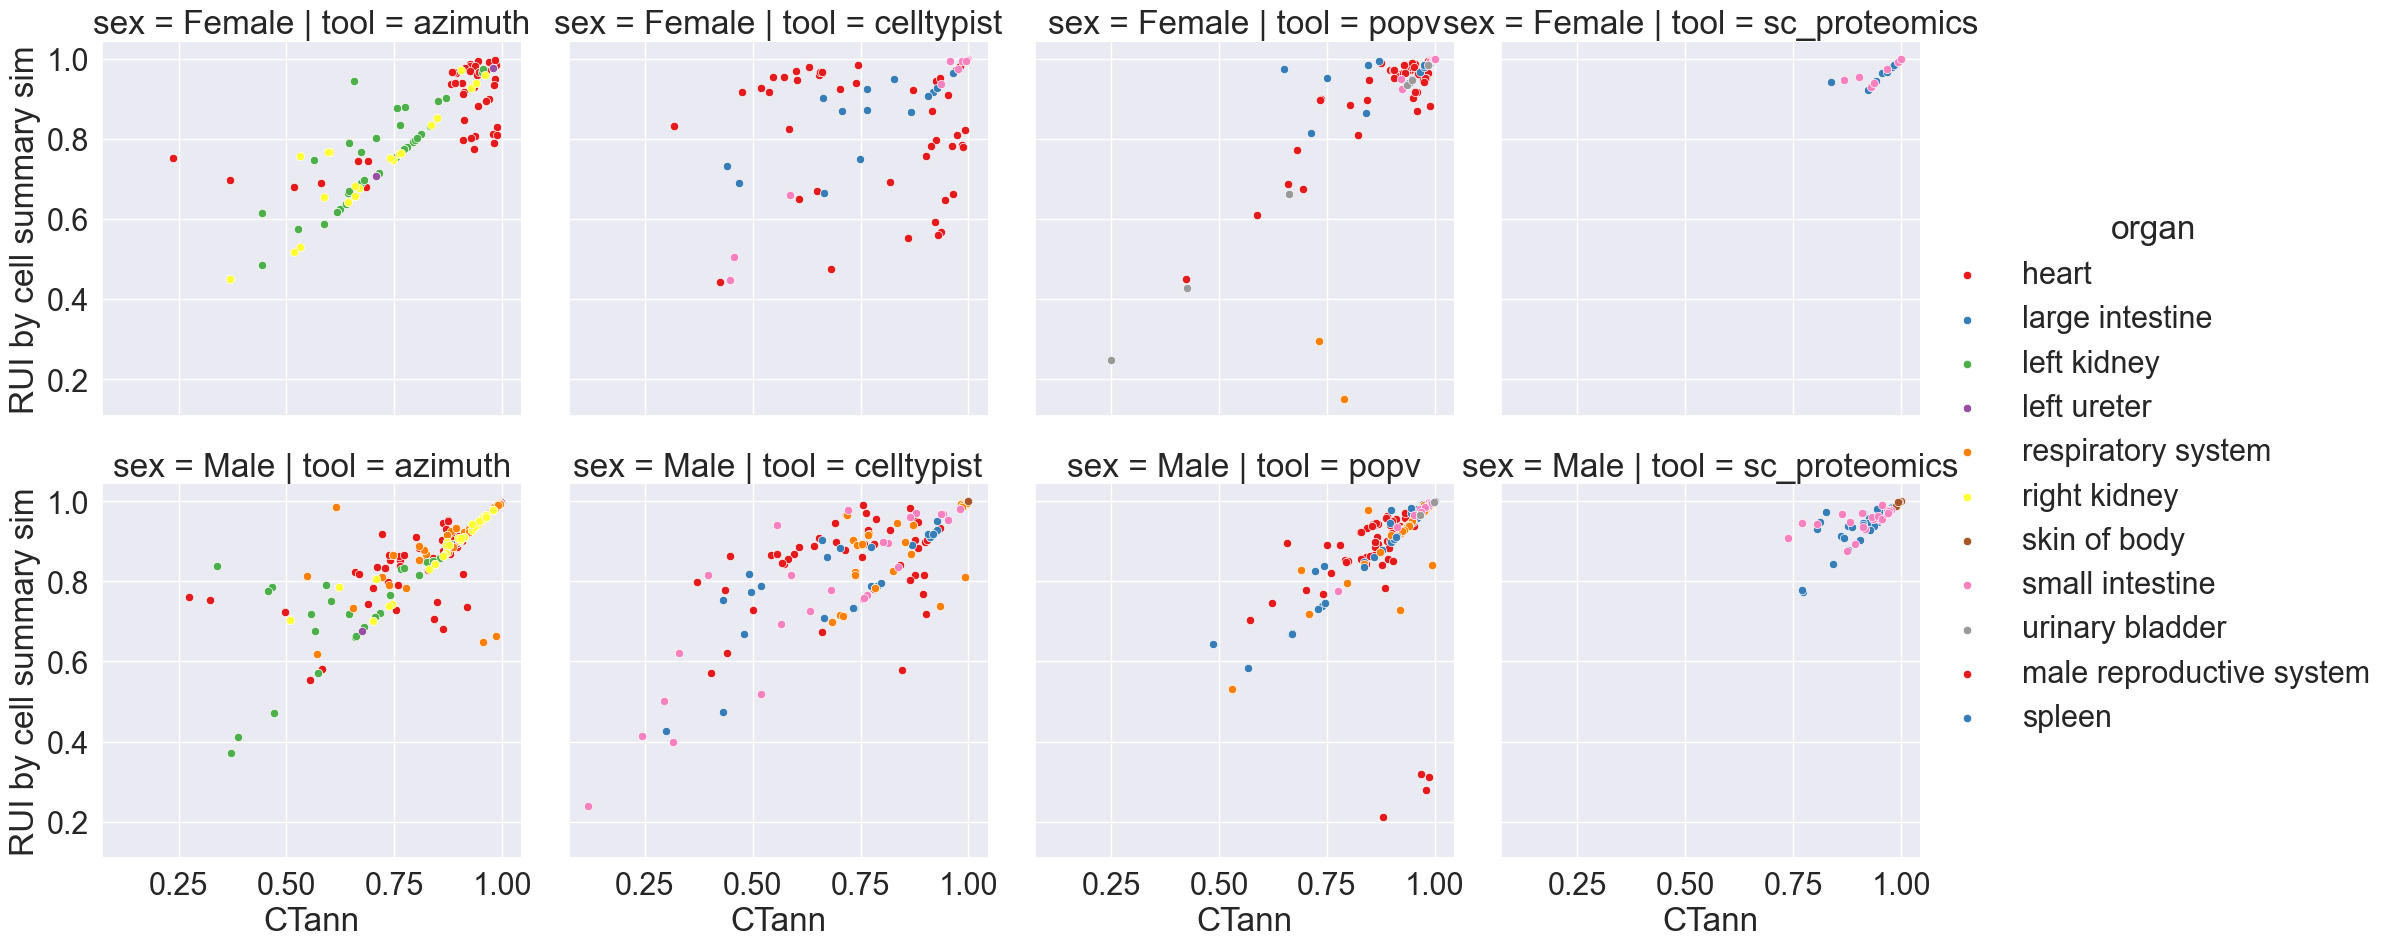

In [15]:
make_validation_scattergraph(
  "ctann_sim", "rui_sim_by_cell_summary", "Set1", "tool", "sex", "organ", "CTann", "RUI by cell summary sim")

### CTann vs RUI AS% similarity &#x274C;


In [33]:
# Correlation
stats = merged_df[['ctann_sim', 'rui_sim_as_percentage']]
stats.corr(min_periods=3)

,ctann_sim,rui_sim_as_percentage
ctann_sim,1.000000,0.225386
rui_sim_as_percentage,0.225386,1.000000


In [17]:
# Mean, STDDEV, min, etc.
stats.describe()

,ctann_sim,rui_sim_as_percentage
count,898.000000,898.000000
mean,0.832648,0.430390
std,0.159287,0.460980
min,0.117205,0.000000
25%,0.743555,0.000000
50%,0.886364,0.132641
75%,0.953453,1.000000
max,1.000000,1.000000


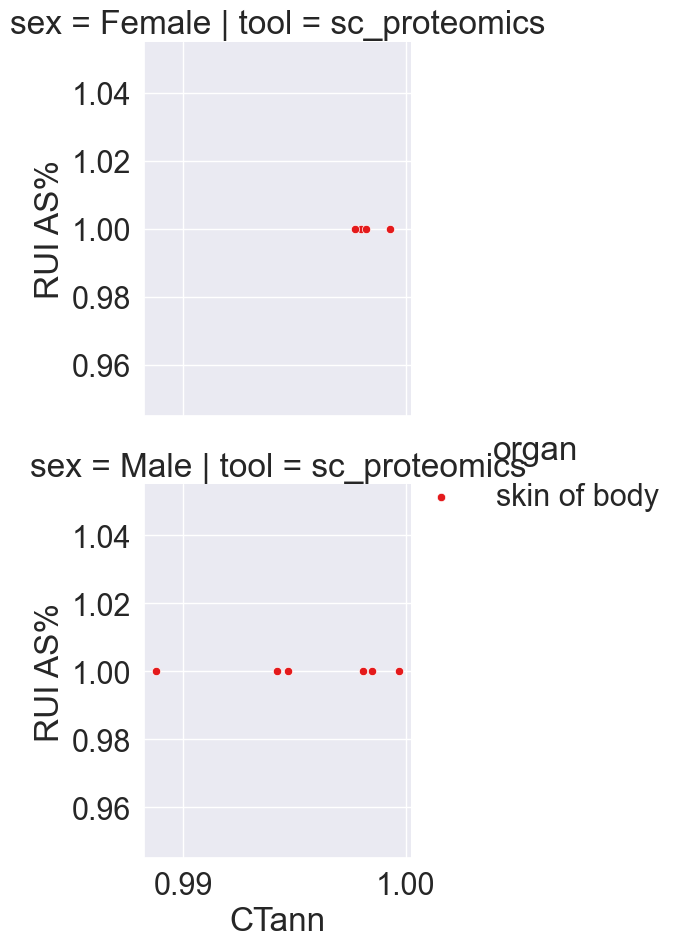

In [36]:
make_validation_scattergraph(
  "ctann_sim", "rui_sim_as_percentage", "Set1", "tool", "sex", "organ", "CTann", "RUI AS%")

## Compute report with non-intersection volume per extraction site


See [https://github.com/x-atlas-consortia/hra-pop/issues/105](https://github.com/x-atlas-consortia/hra-pop/issues/105).
Need this format:
| extraction_site_id | total_intersection_percentage | number_of_AS_collisions | non_intersection_volume |
| --- | --- | --- | --- |
| IRI for extraction site | sum of percentages with all collision items | unique UBERON IDs/FMA IDs in mesh collisions| 1-total_intersection_percentage |


Get extraction site IDs from `ds-graph`


In [19]:
result = {
    'extraction_site_id': [],
    'organ' : [],
    'total_intersection_percentage': [],
    'number_of_AS_collisions': [],
    'non_intersection_volume': []
}

# loop through ds graph
for donor in graph['@graph']:
    for sample in donor['samples']:
        if sample['rui_location']['@id'] in result['extraction_site_id']:
            continue
        result['extraction_site_id'].append(sample['rui_location']['@id'])
        result['organ'].append(sample['rui_location']['placement']['target'])
        total_percentage = 0
        number_of_AS_collisions = 0
        non_intersection_volume = 0
        for all_collisions in sample['rui_location']['all_collisions']:
            for item in all_collisions['collisions']:
                total_percentage += item['percentage']
                number_of_AS_collisions += 1

        non_intersection_volume = 1-total_percentage
        result['total_intersection_percentage'].append(total_percentage)
        result['number_of_AS_collisions'].append(number_of_AS_collisions)
        result['non_intersection_volume'].append(non_intersection_volume)

Convert to DataFrame


In [20]:
df = pd.DataFrame(result)

df

,extraction_site_id,organ,total_intersection_percentage,number_of_AS_collisions,non_intersection_volume
0,http://purl.org/ccf/1.5/e240c0a4-5e53-4464-8320-ad775f2c4bf7,http://purl.org/ccf/latest/ccf.owl#VHFSmallIntestine,0.103,1,0.897
1,http://purl.org/ccf/1.5/f9e28182-3ed3-4a3f-bd45-66ebce1efafb,http://purl.org/ccf/latest/ccf.owl#VHFColon,0.883,1,0.117
2,http://purl.org/ccf/1.5/65f3b03b-1eb1-487d-8c02-c4d107cc9400,http://purl.org/ccf/latest/ccf.owl#VHFSmallIntestine,0.058,2,0.942
3,http://purl.org/ccf/1.5/4ecffbfc-dc50-4140-95e8-4f97d5804f4f,http://purl.org/ccf/latest/ccf.owl#VHFSmallIntestine,0.143,2,0.857
4,http://purl.org/ccf/1.5/93286ce3-669a-4f3f-a85a-7eaaedc15c59,http://purl.org/ccf/latest/ccf.owl#VHFColon,0.052,1,0.948
...,...,...,...,...,...
190,http://purl.org/ccf/1.5/ab2e49b2-1959-44af-8e83-ac16878f6c12,http://purl.org/ccf/latest/ccf.owl#VHMLung,1.000,1,0.000
191,http://purl.org/ccf/1.5/5475ae38-db50-4868-92ba-8718bf136c7b,http://purl.org/ccf/latest/ccf.owl#VHMProstate,1.005,4,-0.005
192,http://purl.org/ccf/1.5/cce37703-e4e8-454c-a0c4-4ff58652ab8f,http://purl.org/ccf/latest/ccf.owl#VHMSkinV1.1,1.000,1,0.000
193,http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864d-ace61789dff6,http://purl.org/ccf/latest/ccf.owl#VHMHeart,0.402,1,0.598


Save to CSV

In [21]:
df.to_csv("output/extraction_site_stats.csv")

Visualize

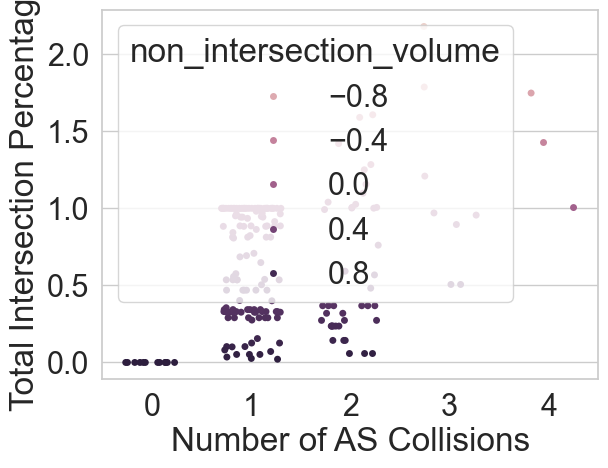

In [22]:

# Create a custom color palette
custom_palette = sns.color_palette("Set2")

g = sns.stripplot(data=df, x='number_of_AS_collisions',
                y='total_intersection_percentage', hue='non_intersection_volume', jitter=0.3)

# Set the style of the plot
# Options: "white", "dark", "whitegrid", "darkgrid", "ticks"
sns.set_style("whitegrid")

# Set labels
g.set(xlabel="Number of AS Collisions", ylabel="Total Intersection Percentage")

# Show the plot
plt.show()

## Check for AS-AS collisions

In [23]:
# import HRA API client
import hra_api_client

In [24]:
# import modules
from hra_api_client.api import v1_api as default_api
from hra_api_client.models.aggregate_count import AggregateCount
from hra_api_client.models.database_status import DatabaseStatus
from hra_api_client.models.error_message import ErrorMessage
from hra_api_client.models.flat_spatial_placement import FlatSpatialPlacement
from hra_api_client.models.get_spatial_placement_request import GetSpatialPlacementRequest
from hra_api_client.models.min_max import MinMax
from hra_api_client.models.ontology_tree import OntologyTree
from hra_api_client.models.sparql_query_request import SparqlQueryRequest
from hra_api_client.models.spatial_entity import SpatialEntity
from hra_api_client.models.spatial_scene_node import SpatialSceneNode
from hra_api_client.models.spatial_search import SpatialSearch
from hra_api_client.models.tissue_block import TissueBlock

from pprint import pprint
from io import StringIO

In [25]:
# config

configuration = hra_api_client.Configuration(
    host="https://apps.humanatlas.io/api"
)

In [26]:
api_client = hra_api_client.ApiClient(configuration)

api_instance = default_api.V1Api(api_client)

In [27]:


query = '''
PREFIX cc: <http://creativecommons.org/ns#>
#+ summary: Table S2
#+ description: Anatomical Structures in HRA, their volume, and predicted CT populations

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX ASCTB-TEMP: <https://purl.org/ccf/ASCTB-TEMP_>
PREFIX CL: <http://purl.obolibrary.org/obo/CL_>
PREFIX FMA: <http://purl.org/sig/ont/fma/fma>
PREFIX UBERON: <http://purl.obolibrary.org/obo/UBERON_>
PREFIX ccf: <http://purl.org/ccf/>
PREFIX CCF: <https://purl.humanatlas.io/graph/ccf>
PREFIX HRApop: <https://purl.humanatlas.io/graph/hra-pop>
PREFIX hra-pop: <https://purl.humanatlas.io/graph/hra-pop#>
PREFIX dc: <http://purl.org/dc/terms/>
PREFIX hubmap: <https://entity.api.hubmapconsortium.org/entities/>
PREFIX rui: <http://purl.org/ccf/1.5/>

SELECT DISTINCT ?organ ?organ_id ?as_label ?as_3d_id ?scene_node ?as_volume 
FROM HRApop:
FROM CCF:
WHERE {
  {
    SELECT ?organ ?as_label (SAMPLE(?as_3d_id) as ?as_3d_id) (SAMPLE(?scene_node) as ?scene_node) (AVG(?as_volume) as ?as_volume)
    WHERE {
      ?rui_location a ccf:SpatialEntity .
      ?rui_location ccf:has_collision_summary [
          ccf:has_collision_item [
            ccf:as_id ?as_id ;
            ccf:as_label ?as_label ;
            ccf:as_volume ?as_volume ;
			ccf:as_3d_id ?as_3d_id ;
            ccf:has_reference_organ ?ref_organ ;
          ]
      ] .
      ?as_3d_id ccf:has_object_reference [
      	ccf:file_subpath ?scene_node ;
      ] .
      BIND (REPLACE(REPLACE(REPLACE(STR(?ref_organ), "http://purl.org/ccf/latest/ccf.owl#", ""), "Colon", "LargeIntestine"), "V1.1", "") as ?organ)
    }
    GROUP BY ?organ ?as_label
  }

  {
    SELECT ?organ ?organ_id
    WHERE {
      ?ref_organ ccf:representation_of ?organ_iri .

      BIND (REPLACE(REPLACE(STR(?organ_iri), 'http://purl.obolibrary.org/obo/UBERON_', 'UBERON:'), 'http://purl.org/sig/ont/fma/fma', 'FMA:') as ?organ_id)
      BIND (REPLACE(REPLACE(REPLACE(STR(?ref_organ), "http://purl.org/ccf/latest/ccf.owl#", ""), "Colon", "LargeIntestine"), "V1.1", "") as ?organ)
    }
  }
  

}
ORDER BY ?organ ?as_label

'''

In [28]:
request = {"query": query}
# use only application/json in format, any other formats will result in errors.
try:
    # help(api_instance.sparql_post)
    api_response = api_instance.sparql_post(
        sparql_query_request=request, format='application/json')
    pprint(api_response)
except hra_api_client.ApiException as e:
    print("Exception when calling DefaultApi->sparql_post: %s\n" % e)

{'head': {'vars': ['organ',
                   'organ_id',
                   'as_label',
                   'as_3d_id',
                   'scene_node',
                   'as_volume']},
 'results': {'bindings': [{'as_3d_id': {'type': 'uri',
                                        'value': 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_papillary_muscle_of_heart_posmed'},
                           'as_label': {'datatype': 'http://www.w3.org/2001/XMLSchema#string',
                                        'type': 'literal',
                                        'value': 'Posteromedial head of '
                                                 'posterior papillary muscle '
                                                 'of left ventricle'},
                           'as_volume': {'datatype': 'http://www.w3.org/2001/XMLSchema#double',
                                         'type': 'literal',
                                         'value': '4401.499'},
                   

In [29]:
# get as_3d_id

unique_as_3d_id_hra_pop = set()

for item in api_response['results']['bindings']:
  unique_as_3d_id_hra_pop.add(item['as_3d_id']['value'])
  
pprint(unique_as_3d_id_hra_pop)

{'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_ascending_colon',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_caecum',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_descending_colon',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_diaphragmatic_surface_of_spleen',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_duodenum_ascending',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_duodenum_descending',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_duodenum_horizontal',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_duodenum_superior',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_fat_R',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_fundus_of_urinary_bladder_base',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_hilum_of_kidney_L',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_hilum_of_spleen',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_ileum',
 'http:

In [30]:
# load CSV from https://github.com/hubmapconsortium/hra-glb-mesh-collisions

as_as_collisions = pd.read_csv("data/collision_results.csv")
# pprint(as_as_collisions)

df_as_mesh = pd.DataFrame(as_as_collisions)

df_as_mesh


# Initialize a list to store results
check_result = []

# Apply a lambda function that checks if any substring in the set is part of the value
df_as_mesh['in_hra_pop'] = df_as_mesh['source'].apply(
    lambda x: any(substring in x for substring in unique_as_3d_id_hra_pop))

df_as_mesh

df_as_mesh.to_csv("output/df_as_mesh.csv")